# Online Calibrated Classification with Dirichlet Pseudo-count Approximation.

## Imports

In [1]:
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq git+https://github.com/probml/dynamax.git
    import dynamax

In [2]:
import numpy as np
import jax
from jax import random as jr
from jax import numpy as jnp

from matplotlib import pyplot as plt

In [3]:
%config InlineBackend.figure_format = 'svg'
from dynamax.utils.plotting import custom_rcparams_notebook
plt.rcParams.update(custom_rcparams_notebook)

## Classification

Consider a classification problem with training data consisting of pairs of inputs $X = \{\mathbf{x}_1, \ldots \mathbf{x}_N\}$ and their corresponding labels $Y = \{y_1, \ldots, y_N\}$. Using this data we want to construct a classifier  to predict the label (or perhaps a probability distribution over labels) given a new input:

$$
\hat{y} = f_\theta(\mathbf{x}).
$$

[Milios et al. (2018)](https://papers.nips.cc/paper/2018/hash/b6617980ce90f637e68c3ebe8b9be745-Abstract.html) present a nice trick, in the context of Gaussian Process Classification, which converts a classification problem into a set of regression problems. 
In their work this allows for the use of much more efficient inference schemes which can take advantage of conjugacy in a GP context.
Here the same trick allows us to use kalman filtering (`dynamax.linear_gaussian_ssm.inference.lgssm_filter`) to perform approximate online classification, traditionally a non-linear problem requiring more complex methods (see, for example, the [cmgf_multiclass_logreg_demo](https://github.com/probml/dynamax/blob/main/dynamax/generalized_gaussian_ssm/demos/cmgf_multiclass_logreg_demo.ipynb)).

#### Plotting Utils

In [4]:
def classifier_class_plot(classifier, X, y, name=None, fig_kwargs=dict()):
    """Plot the predicted probability heatmaps output by a classifier.
    
    Adapated from Alexandre Gramfort's example in:
        https://scikit-learn.org/stable/auto_examples/classification/plot_classification_probability.html
    """
    xx = np.linspace(-5, 5, 100)
    yy = np.linspace(-5, 5, 100).T
    xx, yy = np.meshgrid(xx, yy)
    Xfull = np.c_[xx.ravel(), yy.ravel()]

    classifier.fit(X,y)
    y_pred = classifier.predict(X)

    # View probabilities:
    probas = classifier.predict_proba(Xfull)
    n_classes = np.unique(y_pred).size

    if 'figsize' not in fig_kwargs:
        fig_kwargs['figsize'] = (12,4)
    fig, axs = plt.subplots(1,n_classes, **fig_kwargs)
    for k, ax in enumerate(axs):
        ax.set_title(f"Class {k}")
        ax.imshow(probas[:, k].reshape((100, 100)), 
                  extent=(-5, 5, -5, 5), origin="lower")
        idx_pred_k = y_pred == k
        idx_true_k = y == k
        idx_correct = idx_pred_k & idx_true_k
        idx_incorrect = idx_pred_k & ~idx_true_k
        if idx_correct.any():
            ax.scatter(X[idx_incorrect, 0], X[idx_incorrect, 1], marker="x", c="r",alpha=0.7)
            ax.scatter(X[idx_correct, 0], X[idx_correct, 1], marker="o", c="w", edgecolor="k",alpha=0.6)
        if k == 0:
            ax.set_ylabel(name)
        else:
            ax.set_yticks(())

### Generate Data

We will use this same example data as in this [GPyTorch tutorial](https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/GP_Regression_on_Classification_Labels.html).

The inputs (or covariates), $\mathbf{x} = [x_1, x_2]$, are pushed through a function,

$$
f(\mathbf{x}) = \sin\left(0.15\pi + (x_1 + x_2)\right) + 1,
$$

and discrete labels, $y$, are generated by rounding to the nearest integer,

$$
y = \mathrm{round}(f(\mathbf{x})).
$$

For the data in this analysis we generate N iid samples from a bivariate normal $\mathbf{x}_i \sim \mathcal{N}(\mathbf{0},\mathbf{I})$ and calculate the corresponding labels as described above.

In [5]:
def gen_data(N, key):
    subkey1, subkey2 = jr.split(key)
    X = jr.normal(subkey1, shape=(N,2))
    #u = jr.uniform(subkey2)
    u = 1
    
    f = lambda x, y: jnp.sin(0.15 * u * jnp.pi * (x + y)) + 1
    y_cont = f(*X.T)
    y = jnp.round(y_cont)
    return X, y, f

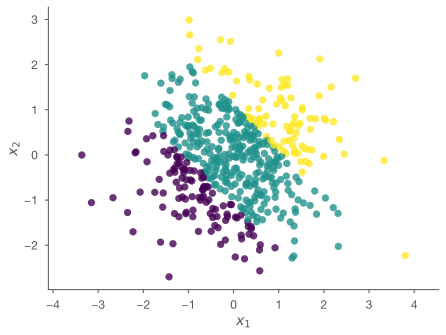

In [6]:
key = jr.PRNGKey(0)
X, y, f = gen_data(500,key)
_, subkey = jr.split(key)
X_test, y_test, _ = gen_data(100, subkey)

plt.scatter(*X.T, c=y,alpha=0.8)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis('equal');

## DirichletKalmanEstimator

As described in [Milios et al. (2018)](https://github.com/probml/dynamax/blob/main/dynamax/generalized_gaussian_ssm/demos/cmgf_multiclass_logreg_demo.ipynb), performing regression on class labels directly often results in poorly calibrated classification.
The neat trick that work is to transform the labels so that they can be thought of as representing pseudo-count parameters in a Dirichlet distribution.

The model is as follows:
$$
\begin{align}
\boldsymbol{\pi} &\sim \textrm{Dir}(\boldsymbol{\alpha})\\
\mathbf{y} | \boldsymbol{\pi} &\sim \textrm{Categorical}(\boldsymbol{\pi})
\end{align}
$$

Here the class label is treated as a one-hot label, that is $\mathbf{y} = [y_1, \ldots, y_K]$, and $y_i = 1$ iff the observation belongs to class k.

Labels are are modelling as being drawn from a categorical distribution parameterised by a probability vector, $\boldsymbol{\pi}$, which is itself distributed according to a Dirichlet distribution with pseudo-count parameter vector, $\boldsymbol{\alpha}$, with elements:

$$
\alpha_i =
\begin{cases}
1 + \alpha_\epsilon &\textrm{if } y_i = 1\\
\alpha_\epsilon &\textrm{if } y_i = 0.
\end{cases}
$$

A sample of a dirichlet random variable $\boldsymbol{\pi} = [\pi_1, \ldots, \pi_K]$ can be generated with K independent Gamma samples:

$$
z_i \sim \textrm{Gamma}(\alpha_i, 1)\\
\pi_i = \frac{z_i}{\sum_{j=1}^K z_j}.
$$

These gamma distributions are approximated by Gaussians in log-space using moment-matching:

$$
\tilde{z}_i \sim \textrm{LogNormal}(\tilde{y}_i, \tilde{\sigma}^2),
$$
where,
$$
\tilde{y}_i = \log \alpha_i - \tilde{\sigma}_i^2/2, \quad \tilde{\sigma}_i^2 = \log(1 / \alpha_i + 1).
$$

These $\tilde{y}_i$ are the regression targets, and the different associated $\tilde{\sigma}_i^2$'s make it a heteroscedastic regression problem.

Once a function approximating $\tilde{y}_i = f_i(\mathbf{x}; \theta)$ has been found then predictions can made with:

$$
\pi_i \approx \frac{\exp(\tilde{y}_i)}{\sum_{j=1}^K \exp(\tilde{y}_j)} =
\frac{\exp(f_i(\mathbf{x}))}{\sum_{j=1}^K \exp(f_j(\mathbf{x}))}.
$$

The classifier `DirichletKalmanEstimator` performs the transform described above and using `lgssm_filter` for online linear regression (see [Online linear regression using Kalman filtering](https://probml.github.io/dynamax/notebooks/linear_gaussian_ssm/kf_linreg.html)) on the transformed targets.

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import log_loss

from dynamax.linear_gaussian_ssm.inference import ParamsLGSSM, lgssm_filter, make_lgssm_params

In [8]:
class DirichletKalmanEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha_eps=0.1, key=jr.PRNGKey(0), N_pred_samples=100):
        """Classifier which works by transforming a classification problem into a set 
         of heteroscedastic regression problems. Calibration is acheived by treating regression
         targets as the pseudo-counts parameterising an appropriate Dirichlet distribution. The
         Gamma marginals of this distribution are approximated with log normals.
         
        From "Dirichlet-based Gaussian Processes for Large-scale Calibrated Classification"
         Milios et al. (2018).
        """
        self.alpha_eps = alpha_eps
        self.key = key
        self.N_pred_samples = N_pred_samples
        self.num_classes = None
        self.mean = None
        self.cov = None

    def fit(self, X, y):
        X_plus_bias = jnp.hstack((jnp.ones((len(X),1)),X))
        
        self.num_classes = len(jnp.unique(y))
        Y_tilde, sigma2_tilde = self._pseudo_count_class_label_transform(y, self.num_classes, self.alpha_eps)
        
        input_dim = X_plus_bias.shape[-1]
        weight_dim = input_dim * self.num_classes
        
        initial_mean, initial_covariance = jnp.zeros(weight_dim), jnp.eye(weight_dim)
        dynamics_weights = jnp.eye(weight_dim)
        dynamics_covariance = jnp.zeros((weight_dim, weight_dim))
        emission_matrix = jnp.stack([jnp.kron(jnp.eye(input_dim), row) for row in X_plus_bias])
        emission_covariance = jnp.stack([jnp.diag(row) for row in sigma2_tilde])
        
        lgssm_params = make_lgssm_params(
                            initial_mean=initial_mean,
                            initial_cov=initial_covariance,
                            dynamics_weights=dynamics_weights,
                            dynamics_cov=dynamics_covariance,
                            emissions_weights=emission_matrix, # (t, D_label, D_input * D_label) 
                            emissions_cov=emission_covariance,
                        )
        
        post = lgssm_filter(lgssm_params, Y_tilde)
        post_means, post_covs = post.filtered_means, post.filtered_covariances
        self.mean, self.cov = post_means[-1], post_covs[-1]
        return self
    
    def predict(self, X, y=None):
        p = self.predict_proba(X)
        return p.argmax(axis=1)
    
    def predict_proba(self,X):
        X_plus_bias = jnp.hstack((jnp.ones((len(X),1)),X))
        W_samples = self._sample_predicted_weights()
        Y_tilde_pred = W_samples @ X_plus_bias.T # N_W_samples x N_classes x len(X)
        return jax.nn.softmax(Y_tilde_pred,axis=1).mean(0).T # len(X) x N_classes
    
    def _sample_predicted_weights(self):
        """Sample weights using posterior mean and covariance."""
        hidden_dim = self.mean.shape[-1]
        Z = jr.normal(self.key,shape=(self.N_pred_samples, hidden_dim))
        W_samples = Z @ self.cov + self.mean
        return W_samples.reshape(self.N_pred_samples,self.num_classes,-1)
    
    def _pseudo_count_class_label_transform(self, y, num_classes, alpha_eps=0.1):
        """Apply the dirichlet pseudo-count transform to class labels.

        Args:
            y: Array (N,) class labels.
            num_classes: int 
            alpha_eps: float in [0,1] tuning parameter for the method.
            
        Returns:
            Y_tilde: Array (N, num_classes), transformed class labels.
            sigma2_tilde: Array (N, num_classes), associated variance terms.
        """
        Y_oh = jax.nn.one_hot(y,num_classes)

        sigma2_tilde = jnp.log(1.0/(Y_oh + alpha_eps) + 1)
        Y_tilde = jnp.log(Y_oh + alpha_eps) - 0.5 * sigma2_tilde

        # Normalise Y_tilde
        class_probs = Y_oh.mean(0)
        ymean = jnp.log(class_probs) + jnp.mean(Y_tilde - jnp.log(class_probs))
        Y_tilde = Y_tilde - ymean
        return Y_tilde, sigma2_tilde

In [9]:
dk_est = DirichletKalmanEstimator()
dk_est.fit(X,y);

In [10]:
yhat = dk_est.predict(X)
dk_est.score(X,y)

0.8

Test data score: 0.91


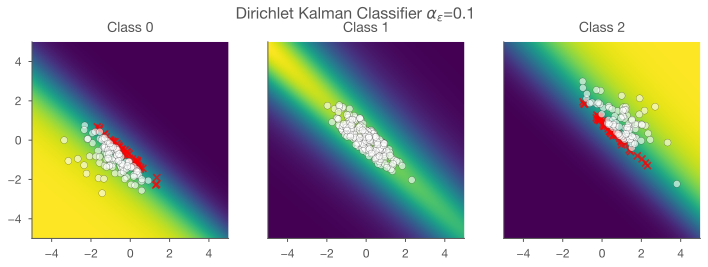

In [11]:
alpha_eps = 0.1
dk_est = DirichletKalmanEstimator(alpha_eps)
classifier_class_plot(dk_est,X,y)
plt.suptitle(r"Dirichlet Kalman Classifier $\alpha_\epsilon$={}".format(alpha_eps));
print(f"Test data score: {dk_est.score(X_test,y_test):.2f}");

Test data score: 0.98


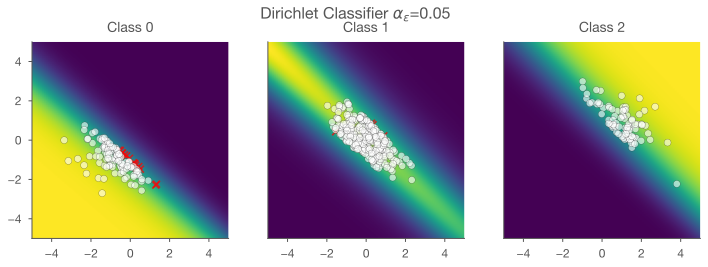

In [12]:
alpha_eps = 0.05
dk_est = DirichletKalmanEstimator(alpha_eps)
classifier_class_plot(dk_est,X,y)
plt.suptitle(r"Dirichlet Classifier $\alpha_\epsilon$={}".format(alpha_eps));
print(f"Test data score: {dk_est.score(X_test,y_test):.2f}");

### Tuning the $\alpha_\epsilon$ parameter

The method has a free parameter $\alpha_\epsilon$ which controls a trade-off between the separation of the $\tilde{Y}$ targets and the size of the variance $\tilde{\sigma}^2$. 

In [13]:
def eval_alpha(alpha_eps, X, y, X_test=None, y_test=None):
    dk_clf = DirichletKalmanEstimator(alpha_eps).fit(X,y)
    X_test = X_test if X_test is not None else X
    y_test = y_test if y_test is not None else y
    score = dk_clf.score(X_test,y_test)
    lloss = log_loss(y_test, dk_clf.predict_proba(X_test))
    return score, lloss

In [14]:
alphas = np.linspace(1e-2,0.2,20)
alpha_scores, alpha_log_losses = np.array([eval_alpha(a,X,y,X_test,y_test) for a in alphas]).T

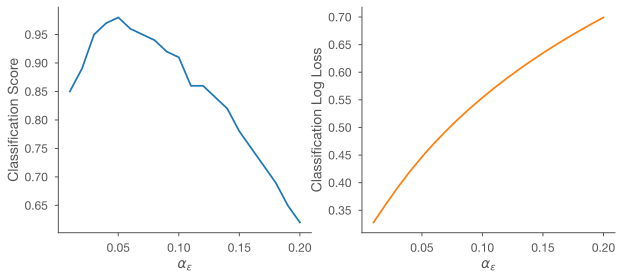

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.plot(alphas, alpha_scores)
ax2.plot(alphas, alpha_log_losses,"C1")

ax1.set_xlabel(r"$\alpha_\epsilon$");
ax1.set_ylabel("Classification Score");

ax2.set_xlabel(r"$\alpha_\epsilon$");
ax2.set_ylabel("Classification Log Loss");

## CMGFEstimator

We will compare this look at the CMGFEstimator classifier class from `cmgf_multiclass_logreg_demo.ipynb` ([found here](https://github.com/probml/dynamax/blob/main/dynamax/cond_moments_gaussian_filter/demos/cmgf_multiclass_logreg_demo.ipynb)).

In [16]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin

from dynamax.generalized_gaussian_ssm import conditional_moments_gaussian_filter, EKFIntegrals, ParamsGGSSM

In [17]:
def fill_diagonal(A, elts):
    # Taken from https://github.com/google/jax/issues/2680
    elts = jnp.ravel(elts)
    i, j = jnp.diag_indices(min(A.shape[-2:]))
    return A.at[..., i, j].set(elts)

In [18]:
class CMGFEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, params, mean=None, cov=None):
        self.params = params
        self.mean = mean
        self.cov = cov

    def fit(self, X, y):
        X_bias = jnp.concatenate([jnp.ones((len(X), 1)), X], axis=1)
        # Encode output as one-hot-encoded vectors with first column dropped,
        # i.e., [0, ..., 0] correspondes to 1st class
        # This is done to prevent the "Dummy Variable Trap".
        enc = OneHotEncoder(drop='first')
        y_oh = jnp.array(enc.fit_transform(y.reshape(-1, 1)).toarray())
        input_dim = X_bias.shape[-1]
        num_classes = y_oh.shape[-1] + 1
        weight_dim = input_dim * num_classes
        
        initial_mean, initial_covariance = jnp.zeros(weight_dim), jnp.eye(weight_dim)
        dynamics_function = lambda w, x: w
        dynamics_covariance = jnp.zeros((weight_dim, weight_dim))
        emission_mean_function = lambda w, x: jax.nn.softmax(x @ w.reshape(input_dim, -1))[1:]
        def emission_var_function(w, x):
            ps = jnp.atleast_2d(emission_mean_function(w, x))
            return fill_diagonal(ps.T @ -ps, ps * (1-ps))
        cmgf_params = self.params(
            initial_mean = initial_mean,
            initial_covariance = initial_covariance,
            dynamics_function = dynamics_function,
            dynamics_covariance = dynamics_covariance,
            emission_mean_function = emission_mean_function,
            emission_cov_function = emission_var_function
        )
        post = conditional_moments_gaussian_filter(cmgf_params, EKFIntegrals(), y_oh, inputs = X_bias)
        post_means, post_covs = post.filtered_means, post.filtered_covariances
        self.mean, self.cov = post_means[-1], post_covs[-1]
        return self
    
    def predict(self, X, y=None):
        p = self.predict_proba(X)
        return jnp.argmax(p, axis=1)
    
    def predict_proba(self,X):
        X_bias = jnp.concatenate([jnp.ones((len(X), 1)), X], axis=1)
        return jax.nn.softmax(X_bias @ self.mean.reshape(X_bias.shape[-1], -1))

In [19]:
cmgf_est = CMGFEstimator(ParamsGGSSM)
cmgf_est.fit(X,y)

CMGFEstimator(cov=DeviceArray([[ 0.3586313 ,  0.32936117,  0.31200793,  0.00762822,
              -0.00958854,  0.00196041,  0.00950449, -0.01115437,
               0.00164988],
             [ 0.3293612 ,  0.34611616,  0.32452267, -0.01020453,
              -0.00089336,  0.01109792, -0.01233433, -0.00097126,
               0.01330556],
             [ 0.31200793,  0.3245227 ,  0.36346948,  0.0025764 ,
               0.01048194, -0.01305829,  0.00282984,  0.0121256 ,
              -0.01495545],
             [ 0.00762821, -...
               0.00592881, -0.00414496,  0.32917014,  0.3450948 ,
               0.32573527],
             [ 0.00164988,  0.01330557, -0.01495543, -0.01178984,
              -0.00402458,  0.01581457,  0.3103262 ,  0.32573524,
               0.3639383 ]], dtype=float32),
              mean=DeviceArray([-0.8751928 ,  2.163629  , -1.2884345 , -2.5025227 ,
             -0.02651652,  2.5290387 , -2.7178888 ,  0.00295021,
              2.7149343 ], dtype=float32),
       

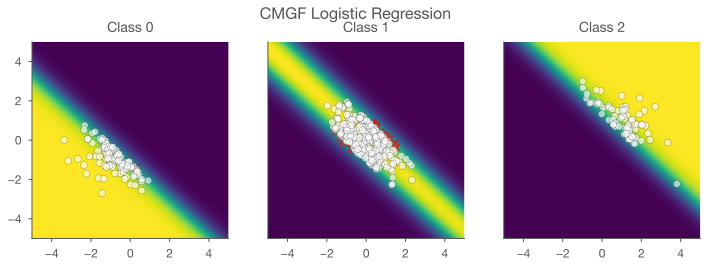

In [20]:
classifier_class_plot(cmgf_est,X,y)
plt.suptitle("CMGF Logistic Regression");